In [57]:
import xarray as xr
from dask.distributed import LocalCluster, Client
import dask
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

In [2]:
client = Client(LocalCluster())

2022-10-19 15:07:20,463 - distributed.diskutils - INFO - Found stale lock file and directory '/lus/cls04005/shao/analysis/NEP36_cluster_analysis/dask-worker-space/worker-u39uwkrl', purging
2022-10-19 15:07:20,466 - distributed.diskutils - INFO - Found stale lock file and directory '/lus/cls04005/shao/analysis/NEP36_cluster_analysis/dask-worker-space/worker-0ty3bzt6', purging
2022-10-19 15:07:20,469 - distributed.diskutils - INFO - Found stale lock file and directory '/lus/cls04005/shao/analysis/NEP36_cluster_analysis/dask-worker-space/worker-uuvtqty_', purging
2022-10-19 15:07:20,472 - distributed.diskutils - INFO - Found stale lock file and directory '/lus/cls04005/shao/analysis/NEP36_cluster_analysis/dask-worker-space/worker-sx39y1hf', purging
2022-10-19 15:07:20,475 - distributed.diskutils - INFO - Found stale lock file and directory '/lus/cls04005/shao/analysis/NEP36_cluster_analysis/dask-worker-space/worker-8q2vhsrt', purging
2022-10-19 15:07:20,477 - distributed.diskutils - INFO 

In [3]:
datapath = '/lus/scratch/shao/data/NEP36_extremes/'
cluster_files = glob.glob('output_data/cluster*.nc')
clusters_ds = [ xr.open_dataset(file, chunks={'time':439}, engine='h5netcdf') for file in cluster_files ]

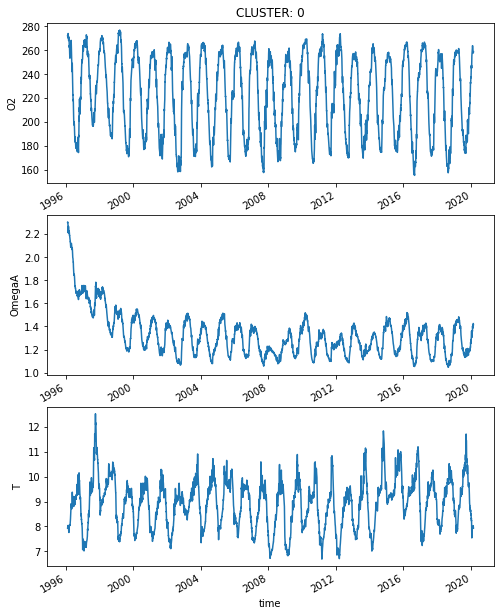

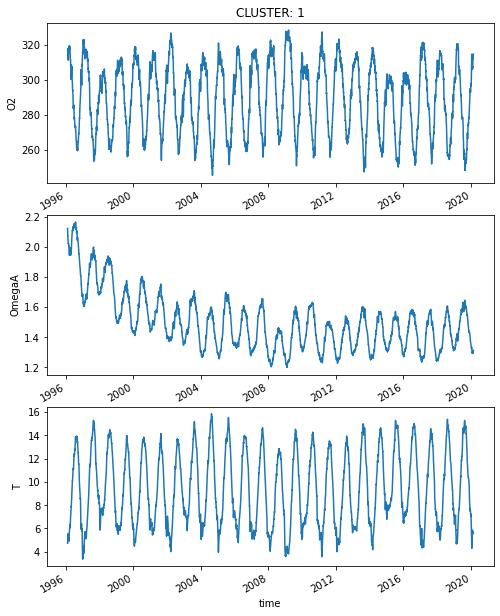

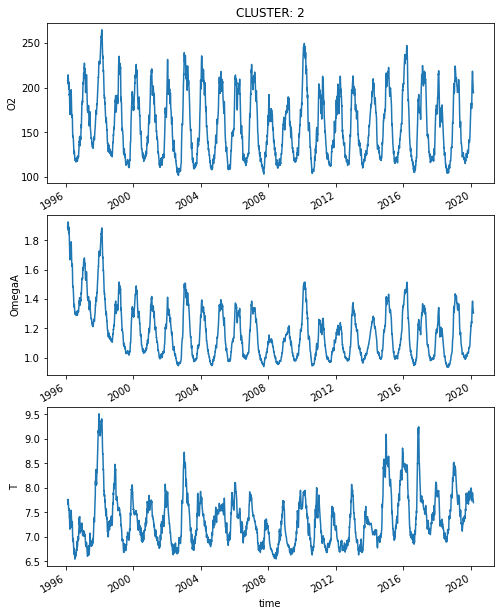

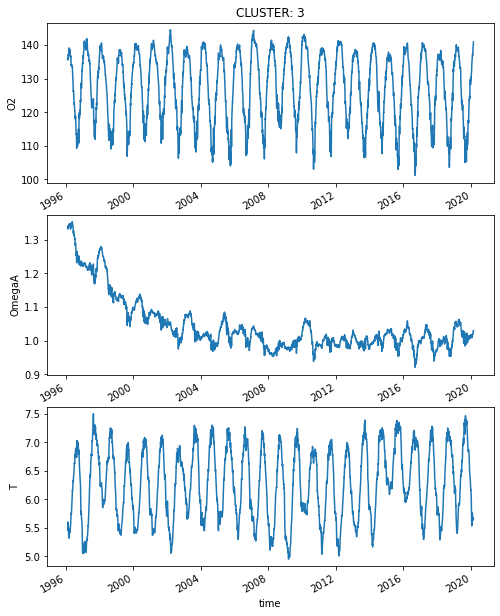

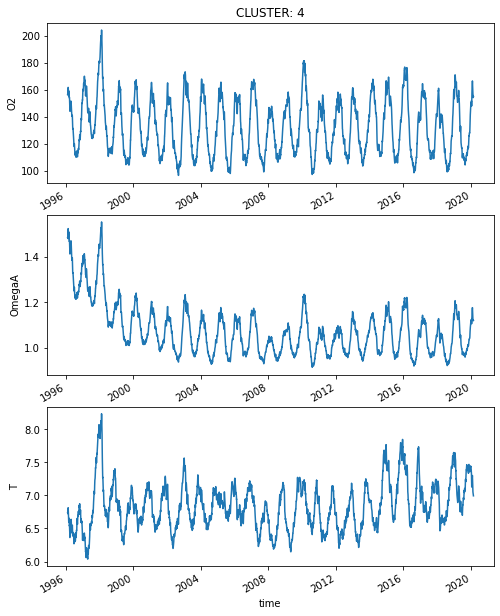

In [6]:
# Plot timeseries of all the relevant variables
timeseries_vars = [
    'O2',
    'OmegaA',
    'T'
]

for cluster_label, cluster_ds in enumerate(clusters_ds):
    plt.figure(figsize=(8,10))    
    for idx, var in enumerate(timeseries_vars):        
        plt.subplot(3,1,idx+1)
        cluster_ds[var].mean('stacked_y_x').plot()
        if idx == 0:
            plt.title(f'CLUSTER: {cluster_label}')
    

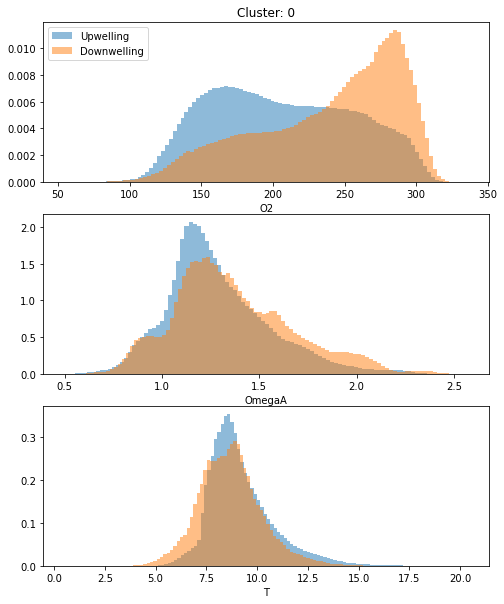

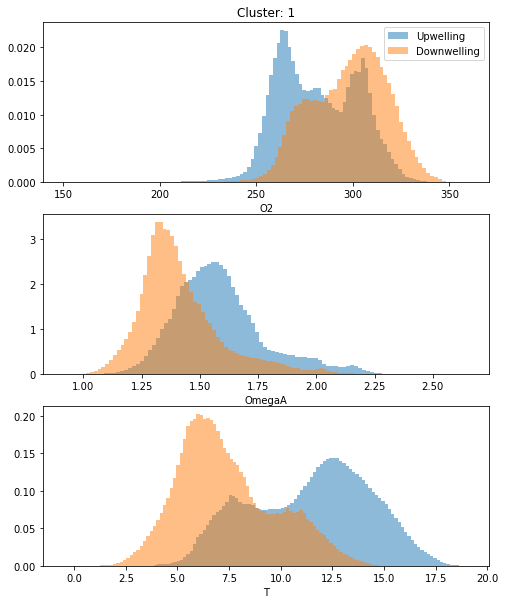

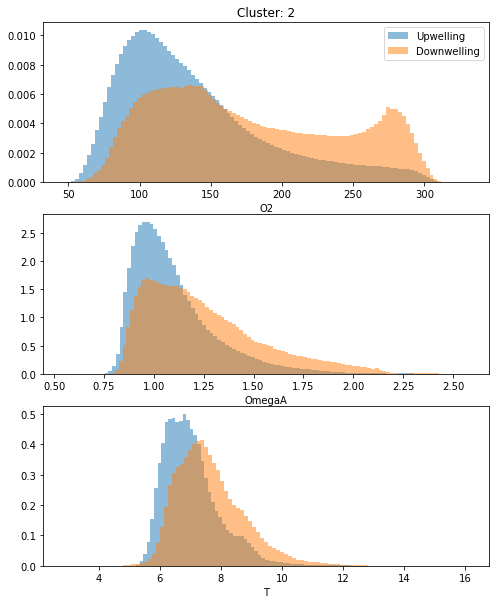

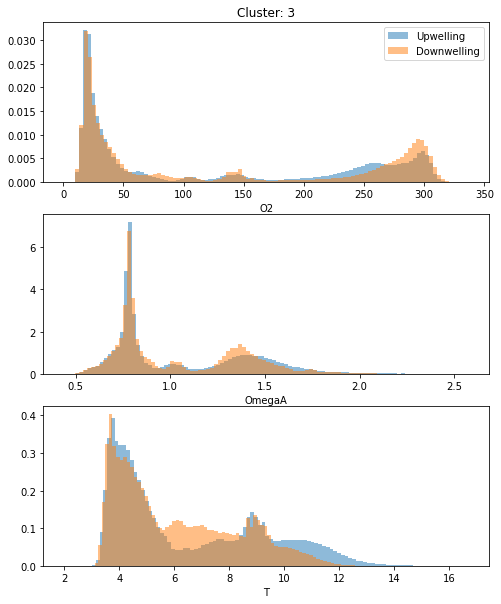

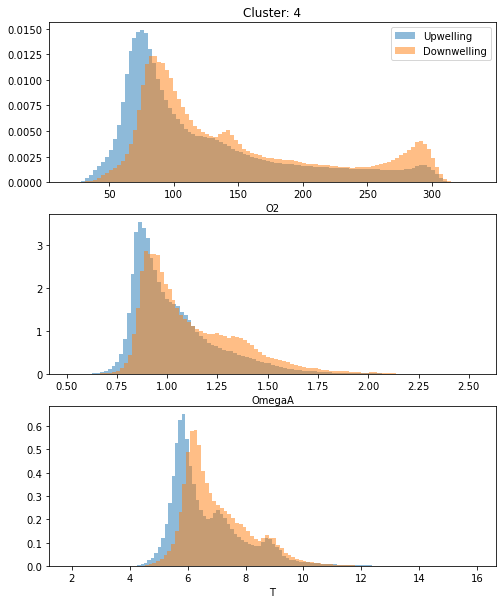

In [50]:
# Split by upwelling season
downwelling_months = [10, 11, 12, 1, 2, 3]
upwelling_months   = [4, 5, 6, 7, 8, 9]
timeseries_vars = ['O2','OmegaA','T']
hist_kwargs = {
    'alpha':0.5,
    'density':True,
    'bins':100
}

def filter_by_season_and_values(ds,month_range):       
    ds_out = ds.where(ds['time.month'].isin(month_range),drop=True)
    ds_out = ds_out.where(ds_out.O2 != 0., drop=True)
    return ds_out


for cluster_label, cluster_ds in enumerate(clusters_ds):
    plt.figure(figsize=(8,10))
    ds_months = cluster_ds.groupby('time.month')    
    # For every dataset separate data in upwelling and downwelling months
    upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)
    downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)
    for idx, var in enumerate(timeseries_vars):         
        plt.subplot(3,1,idx+1)
        plt.hist(upwelling_ds[var].to_numpy().flatten(),label='Upwelling', **hist_kwargs)
        plt.hist(downwelling_ds[var].to_numpy().flatten(),label='Downwelling', **hist_kwargs)
        plt.xlabel(var)
        if idx == 0:
            plt.title(f'Cluster: {cluster_label}')
            plt.legend()

Cluster label: 0
	O2 Upwelling: 54.17733383178711
	O2 Downwelling: 59.650569915771484
	OmegaA Upwelling: 0.5048758443497109
	OmegaA Downwelling: 0.5545656892123538
	T Upwelling: 4.571915382146836
	T Downwelling: 2.160661905258894
Cluster label: 1
	O2 Upwelling: 150.48818969726562
	O2 Downwelling: 159.22593688964844
	OmegaA Upwelling: 1.0240700671289344
	OmegaA Downwelling: 0.9416955399902033
	T Upwelling: 3.564444831609726
	T Downwelling: -0.252406173485976
Cluster label: 2
	O2 Upwelling: 46.93067932128906
	O2 Downwelling: 54.281185150146484
	OmegaA Upwelling: 0.565245122430593
	OmegaA Downwelling: 0.7101669725566823
	T Upwelling: 4.5710006326437
	T Downwelling: 3.3891586953943427
Cluster label: 3
	O2 Upwelling: 0.6683756709098816
	O2 Downwelling: 0.6745977997779846
	OmegaA Upwelling: 0.4725056856724123
	OmegaA Downwelling: 0.4522948460484029
	T Upwelling: 3.043418564383439
	T Downwelling: 2.80006293853124
Cluster label: 4
	O2 Upwelling: 20.042631149291992
	O2 Downwelling: 22.225200653

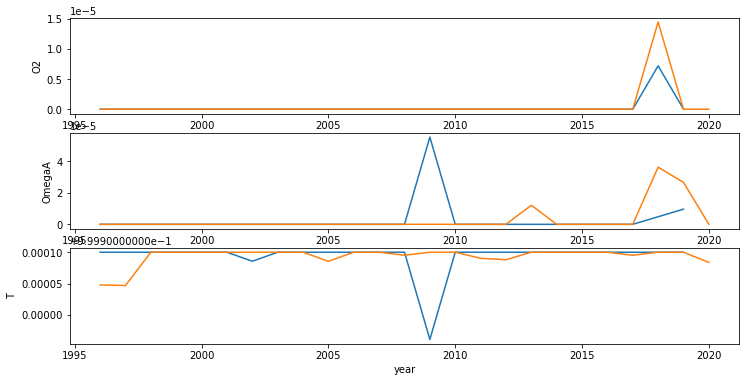

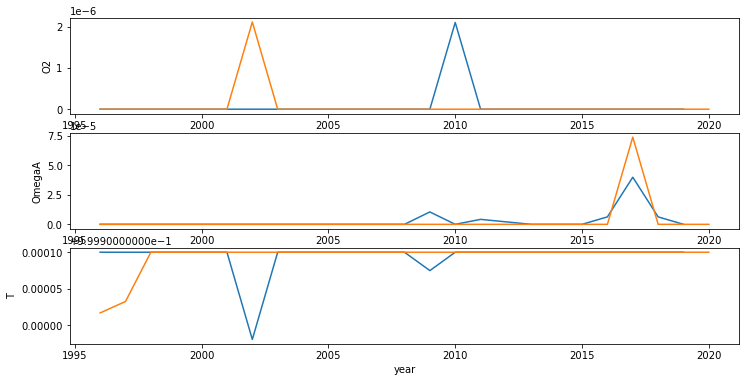

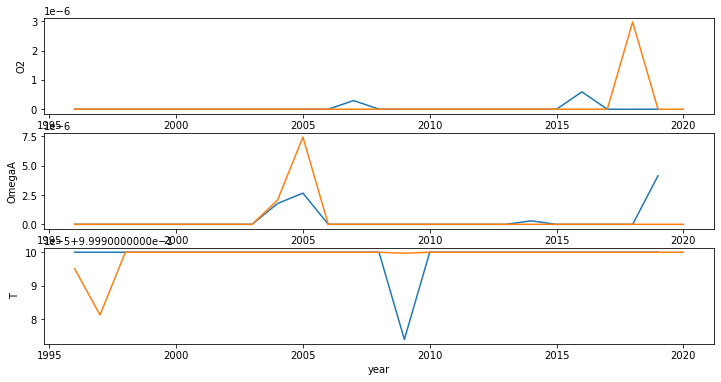

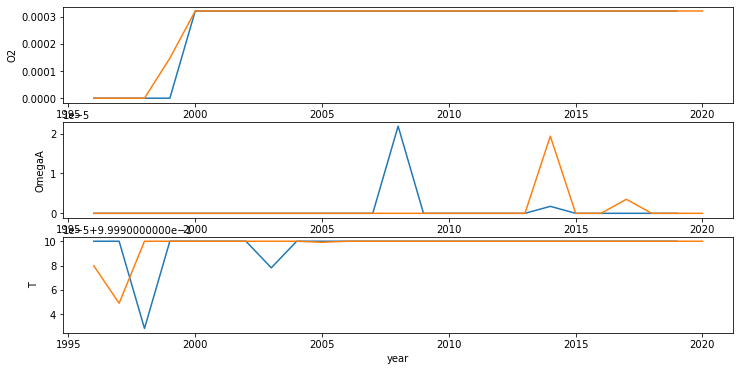

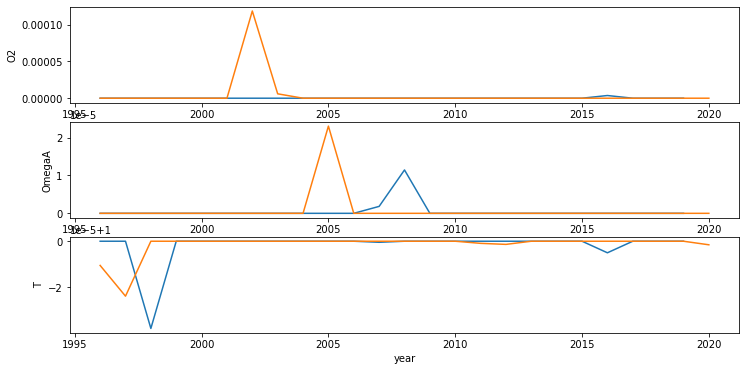

In [79]:
# Calculate extreme thresholds by upwelling/downwelling season and plot timeseries of percentage extremes
downwelling_months = [10, 11, 12, 1, 2, 3]
upwelling_months   = [4, 5, 6, 7, 8, 9]
timeseries_vars = ['O2','OmegaA','T']
hist_kwargs = {
    'alpha':0.5,
    'density':True,
    'bins':100
}

base_percentile = 0.05
percentiles = {
    'O2':base_percentile,
    'OmegaA':base_percentile,
    'T':1-base_percentile
}

def filter_by_season_and_values(ds,month_range):       
    ds_out = ds.where(ds['time.month'].isin(month_range),drop=True)
    ds_out = ds_out.where(ds_out.O2 != 0., drop=True)
    return ds_out

def calculate_threshold(ds, percentile, nbins=1000):
    data = ds.to_numpy().flatten()
    hist, edges = np.histogram(data, bins=nbins)
    cdf = integrate.cumtrapz(hist,edges[1:])
    return np.interp(percentile, cdf, edges[2:])    

def plot_fraction_extreme(ds, threshold, extreme_is_low, label):
    if extreme_is_low:
        is_extreme = ds <= threshold
    else:
        is_extreme = ds >= threshold    
    npts = len(ds.stacked_y_x)
    frac_extreme = is_extreme.sum('stacked_y_x')/npts
    frac_extreme.groupby('time.year').mean(dim='time').plot(label=label)     
    

for cluster_label, cluster_ds in enumerate(clusters_ds):    
    ds_months = cluster_ds.groupby('time.month')
    
    # For every dataset separate data in upwelling and downwelling months
    upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)    
    downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)    
    print(f'Cluster label: {cluster_label}')
    plt.figure(figsize=(12,6))
               
    for idx, var in enumerate(timeseries_vars):         
        plt.subplot(3,1,idx+1)
        percentile = percentiles[var]
        upwelling_threshold = calculate_threshold(upwelling_ds[var],percentile)
        downwelling_threshold = calculate_threshold(downwelling_ds[var],percentile)
        print(f'\t{var} Upwelling: {upwelling_threshold}')
        print(f'\t{var} Downwelling: {downwelling_threshold}')
        plot_fraction_extreme(upwelling_ds[var], upwelling_threshold, percentile == base_percentile, 'Upwelling')
        plot_fraction_extreme(downwelling_ds[var], downwelling_threshold, percentile == base_percentile, 'Downwelling')
         
